<a href="https://colab.research.google.com/github/Min-eralwater/Projects/blob/master/Clinic_Queue_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Packages**

In [0]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline
np.random.seed(1)

**Function for Simulation**

In [0]:
def hospital_simulation(registration_staffs,doctors,slots):
        
    patients = pd.DataFrame()
    patients['Patient ID'] = range(1,slots+1)
    patients['Arrival Time Taken'] = np.random.random_sample(slots)
    patients['Arrival Time Taken'] = np.where(patients['Arrival Time Taken']<=0.5,5,patients['Arrival Time Taken'])
    patients['Arrival Time Taken'] = np.where(np.logical_and(patients['Arrival Time Taken']>0.5,patients['Arrival Time Taken']<=0.8),10,patients['Arrival Time Taken'])
    patients['Arrival Time Taken'] = np.where(np.logical_and(patients['Arrival Time Taken']>0.8,patients['Arrival Time Taken']<=1),15,patients['Arrival Time Taken'])
    patients['Arrival Time Taken'] = np.where(patients['Arrival Time Taken']<=0.5,5,patients['Arrival Time Taken'])
    patients['Arrival Start Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots
    patients['Arrival End Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots
    patients['Registration Time Taken'] = [7.]*slots
    patients['Registration Start Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots
    patients['Registration End Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots
    patients['Consultation Time Taken'] = np.random.random_sample(slots)
    patients['Consultation Time Taken'] = np.where(patients['Consultation Time Taken']<=0.3,4,patients['Consultation Time Taken'])
    patients['Consultation Time Taken'] = np.where(np.logical_and(patients['Consultation Time Taken']>0.3,patients['Consultation Time Taken']<=0.8),8,patients['Consultation Time Taken'])
    patients['Consultation Time Taken'] = np.where(np.logical_and(patients['Consultation Time Taken']>0.8,patients['Consultation Time Taken']<=1),12,patients['Consultation Time Taken'])
    patients['Consultation Start Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots
    patients['Consultation End Time'] = [pd.to_datetime('08:00', format='%H:%M')]*slots

    current_arrival_time = pd.to_datetime('08:00', format='%H:%M')
    current_registration_time = pd.to_datetime('08:00', format='%H:%M')+ pd.Timedelta(minutes=patients.loc[0,'Arrival Time Taken'])
    registration_time = []
    for j in range(registration_staffs):
        registration_time.append(current_registration_time)
    current_consultation_time = pd.to_datetime('08:00', format='%H:%M')+ pd.Timedelta(minutes=patients.loc[0,'Arrival Time Taken'])+ pd.Timedelta(minutes=patients.loc[0,'Registration Time Taken'])
    consultation_time = []
    for k in range(doctors):
        consultation_time.append(current_consultation_time)
    for i in range(patients.shape[0]):
        patients.loc[i,'Arrival Start Time'] = current_arrival_time
        patients.loc[i,'Arrival End Time'] = current_arrival_time + pd.Timedelta(minutes=patients.loc[i,'Arrival Time Taken'])
        current_arrival_time = patients.loc[i,'Arrival End Time']
        patients.loc[i,'Registration Start Time'] = max(min(registration_time),patients.loc[i,'Arrival End Time'])
        patients.loc[i,'Registration End Time'] = patients.loc[i,'Registration Start Time'] + pd.Timedelta(minutes=patients.loc[i,'Registration Time Taken'])
        registration_time[registration_time.index(min(registration_time))] = patients.loc[i,'Registration End Time']
        patients.loc[i,'Consultation Start Time'] = max(min(consultation_time),patients.loc[i,'Registration End Time'])
        patients.loc[i,'Consultation End Time'] = patients.loc[i,'Consultation Start Time'] + pd.Timedelta(minutes=patients.loc[i,'Consultation Time Taken'])
        consultation_time[consultation_time.index(min(consultation_time))] = patients.loc[i,'Consultation End Time']
    
    patients['Arrival Start Time'] = patients['Arrival Start Time'].dt.time
    patients['Arrival End Time'] = patients['Arrival End Time'].dt.time
    patients['Registration Start Time'] = patients['Registration Start Time'].dt.time
    patients['Registration End Time'] = patients['Registration End Time'].dt.time
    patients['Consultation Start Time'] = patients['Consultation Start Time'].dt.time
    patients['Consultation End Time'] = patients['Consultation End Time'].dt.time
    
    return(patients)

**Example**

In [0]:
hospital_simulation(2,1,30).head()

,Patient ID,Arrival Time Taken,Arrival Start Time,Arrival End Time,Registration Time Taken,Registration Start Time,Registration End Time,Consultation Time Taken,Consultation Start Time,Consultation End Time
0,1,5.0,08:00:00,08:05:00,7.0,08:05:00,08:12:00,4.0,08:12:00,08:16:00
1,2,10.0,08:05:00,08:15:00,7.0,08:15:00,08:22:00,8.0,08:22:00,08:30:00
2,3,5.0,08:15:00,08:20:00,7.0,08:20:00,08:27:00,12.0,08:30:00,08:42:00
3,4,5.0,08:20:00,08:25:00,7.0,08:25:00,08:32:00,8.0,08:42:00,08:50:00
4,5,5.0,08:25:00,08:30:00,7.0,08:30:00,08:37:00,8.0,08:50:00,08:58:00


**Function for Simulating with Multiple Days with Cost Calculation**

In [0]:
def days_simulation(registration_staffs, doctors, slots, days, close_at='12:30:00'):
    open_time = []
    ot_time = []
    registration_wait = []
    consultation_wait = []
    
    for day in tqdm(range(days)):
        temp_data = hospital_simulation(registration_staffs, doctors, slots)
        temp_data['Arrival End Time'] = temp_data['Arrival End Time'].apply(lambda x: pd.to_timedelta(str(x)))
        temp_data['Consultation Start Time'] = temp_data['Consultation Start Time'].apply(lambda x: pd.to_timedelta(str(x)))
        temp_data['Consultation End Time'] = temp_data['Consultation End Time'].apply(lambda x: pd.to_timedelta(str(x)))
        temp_data['Registration End Time'] = temp_data['Registration End Time'].apply(lambda x: pd.to_timedelta(str(x)))
        temp_data['Registration Start Time'] = temp_data['Registration Start Time'].apply(lambda x: pd.to_timedelta(str(x)))

        open_time.append((max(temp_data['Consultation End Time']) - pd.to_timedelta('08:00:00')))
        ot_time.append(max(pd.to_timedelta('00:00:00'), (max(temp_data['Consultation End Time']) - pd.to_timedelta(close_at))).seconds/60)

        registration_wait.append((temp_data['Registration Start Time'] - temp_data['Arrival End Time']).apply(lambda x: x.seconds/60).mean())
        consultation_wait.append((temp_data['Consultation Start Time'] - temp_data['Registration End Time']).apply(lambda x: x.seconds/60).mean())
        
    staff_ot_pay = ((np.array(ot_time) / 15)*7)*registration_staffs
    doctor_ot_pay = ((np.array(ot_time) / 15)*30)* doctors
    
    add_staff_pay = (registration_staffs-1)*12*4.5 + 12 * (pd.to_timedelta(close_at) - pd.to_timedelta('12:30:00')).seconds / 3600
    add_doctor_pay = (doctors-1)*50*4.5 + 50 * (pd.to_timedelta(close_at) - pd.to_timedelta('12:30:00')).seconds / 3600

    df = pd.DataFrame({
                       'Open Time': open_time,
                       'OT Time': ot_time, 
                       'Staff OT Fees': staff_ot_pay,
                       'Doctor OT Fees': doctor_ot_pay,
                       'Extra Staff Fees': add_staff_pay,
                       'Extra Doctor Fees': add_doctor_pay,
                       'Registration Waiting Time': registration_wait, 
                       'Consultation Waiting Time': consultation_wait,
                       })
    return df

**Function to give Summary Statistics**

In [0]:
def simulation_stats(registration_staffs, doctors, slots, days, close_at='12:30:00'):
    df = days_simulation(registration_staffs, doctors, slots, days, close_at)
    return pd.DataFrame({
            'Mean Open Time': [df['Open Time'].mean()],
            'Total OT Time': [df['OT Time'].sum()], 
            'Total Staff OT Fees': [df['Staff OT Fees'].sum()],
            'Total Doctor OT Fees': [df['Doctor OT Fees'].sum()],
            'Total Extra Staff Fees': [df['Extra Staff Fees'].sum()],
            'Total Extra Doctor Fees': [df['Extra Doctor Fees'].sum()],
            'Mean Registration Waiting Time': [df['Registration Waiting Time'].mean()], 
            'Mean Consultation Waiting Time': [df['Consultation Waiting Time'].mean()],
            })

**Plotting out the Boxplot**

100%|██████████| 30/30 [00:06<00:00,  4.62it/s]


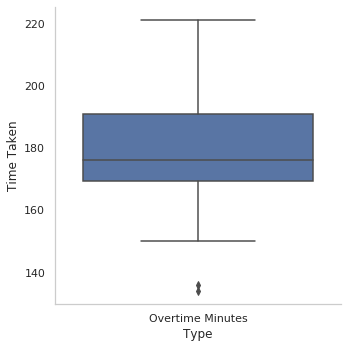

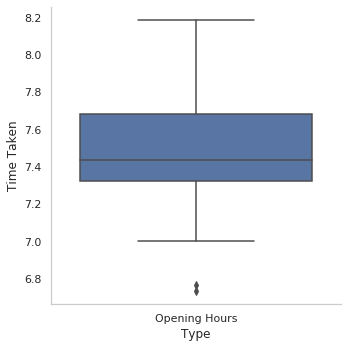

In [0]:
df = days_simulation(registration_staffs=1, doctors=1, slots=50, days=30, close_at='12:30:00')

plot_df = pd.DataFrame()
plot_df['Type'] = ['Opening Hours']*30+['Overtime Minutes']*30
plot_df['Time Taken'] = list(pd.to_timedelta(df['Open Time']).dt.seconds/60**2) + list(df['OT Time'])

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.catplot(x='Type',y='Time Taken', data=plot_df[plot_df['Type']=='Overtime Minutes'],kind="box",dodge="False")
sns.catplot(x='Type',y='Time Taken', data=plot_df[plot_df['Type']=='Opening Hours'],kind="box",dodge="False")

**Testing for 30 Patients in 30 Days by Changing the Number of Staffs and Doctors**

In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=1, doctors=1, slots=30, days=30, close_at='12:30:00') # 1 staff, 1 doctor


100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,04:45:42,538.0,251.066667,1076.0,0.0,0.0,2.182222,4.626667


In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=2, doctors=1, slots=30, days=30, close_at='12:30:00') # 2 staffs, 1 doctor

100%|██████████| 30/30 [00:05<00:00,  5.66it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,04:45:06,524.0,489.066667,1048.0,1620.0,0.0,0.0,6.132222


In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=1, doctors=2, slots=30, days=30, close_at='12:30:00') # 1 staff, 2 doctors

100%|██████████| 30/30 [00:05<00:00,  5.74it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,04:39:02,383.0,178.733333,1532.0,0.0,6750.0,2.182222,0.0


In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=2, doctors=2, slots=30, days=30, close_at='12:30:00') # 2 staffs, 2 doctors

100%|██████████| 30/30 [00:05<00:00,  6.11it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,04:36:30,341.0,318.266667,1364.0,1620.0,6750.0,0.0,0.064444


**Testing for 30 Patients in 30 Days by Extending Overtime by 15 minutes**

In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=1, doctors=1, slots=30, days=30, close_at='12:45:00') 

100%|██████████| 30/30 [00:05<00:00,  6.01it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,04:45:42,203.0,94.733333,406.0,90.0,375.0,2.182222,4.626667


**Testing for 50 Patients in 30 Days by Changing the Number of Staffs and Doctors**

In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=1, doctors=1, slots=50, days=30, close_at='12:30:00') # 1 staff, 1 doctor

100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,07:31:10,5435.0,2536.333333,10870.0,0.0,0.0,2.534,4.700667


In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=2, doctors=2, slots=50, days=30, close_at='12:30:00') # 2 staffs, 2 doctors

100%|██████████| 30/30 [00:07<00:00,  3.86it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,07:22:10,5165.0,4820.666667,20660.0,1620.0,6750.0,0.0,0.07


**Testing for 50 Patients in 30 Days by Extending Overtime by 15 minutes**

In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=1, doctors=1, slots=50, days=30, close_at='15:30:00') 

100%|██████████| 30/30 [00:07<00:00,  3.87it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,07:31:10,249.0,116.2,498.0,1080.0,4500.0,2.534,4.700667


**Testing for 50 Patients in 30 Days by Extending Overtime by 15 minutes and Changing the Number of Staffs and Doctors**

In [0]:
np.random.seed(1)
simulation_stats(registration_staffs=2, doctors=2, slots=50, days=30, close_at='15:30:00')

100%|██████████| 30/30 [00:07<00:00,  3.73it/s]


,Mean Open Time,Total OT Time,Total Staff OT Fees,Total Doctor OT Fees,Total Extra Staff Fees,Total Extra Doctor Fees,Mean Registration Waiting Time,Mean Consultation Waiting Time
0,07:22:10,175.0,163.333333,700.0,2700.0,11250.0,0.0,0.07
